In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_DIR = "./rawdata/geneticdata/DBPLIC1_wSCORECLass.txt"
genetic_data = pd.read_csv(DATA_DIR,delimiter='\t')
updated_genetic_data = genetic_data.drop(labels=['cod_pz','Unnamed: 0','Score',],axis=1)
updated_genetic_data.fillna({'ScoreClass':-2}, inplace=True)
updated_genetic_data.head()

#Clean out binned data
genetic_columns = list(updated_genetic_data.columns)
todrop_genetic_columns = []
counter = 0
for index, value in enumerate(genetic_columns):
    if ('VS') in value:
        todrop_genetic_columns.append(value)
        counter += 1
    elif('vs' in value):
        todrop_genetic_columns.append(value)
        counter += 1
    elif('1_2e3' in value):
        todrop_genetic_columns.append(value)
        counter += 1
        
final_data = updated_genetic_data.drop(labels=todrop_genetic_columns,axis=1)

final_data.apply(pd.to_numeric)

cleaned_data = final_data.dropna(subset=['SCORE']) 
cleaned_data.describe()

,BPIFB4 rs2070325,ST6GAL1_rs11710456,SLC2A2_rs5400,CD36_rs1761667,CD36_rs1049673,ZC3H10_rs61732294,HDAC1_rs1741981,HDAC3_rs2547547,HDAC3_rs2530223,SLC5A12_rs138192976,...,rs_1799945,rs_1800562,rs_2736100,rs_10936599,rs_7675998,rs_9420907,rs_8105767,rs_755017,SCORE,ScoreClass
count,1159.000000,1174.000000,1266.000000,1223.000000,1239.000000,1272.000000,1261.000000,1253.000000,1269.000000,1271.0,...,937.000000,956.000000,938.000000,999.000000,944.000000,990.000000,980.000000,930.000000,1445.000000,1445.000000
mean,1.688525,1.573254,1.334123,2.005724,2.066182,1.545597,1.247423,1.335196,1.877857,1.0,...,1.267876,1.042887,1.904051,1.471471,1.500000,1.344444,1.541837,1.122581,2.851420,2.216609
std,0.706836,0.635146,0.588201,0.721972,0.697661,0.501261,0.472081,0.577270,0.687924,0.0,...,0.471136,0.207810,0.734400,0.608010,0.629767,0.544802,0.635424,0.337830,3.643885,1.163623
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-2.000000
25%,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.518080,1.000000
50%,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.0,...,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.598360,2.000000
75%,2.000000,2.000000,2.000000,3.000000,3.000000,2.000000,1.000000,2.000000,2.000000,1.0,...,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.816545,3.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.0,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,30.489526,4.000000


In [3]:
#n = how many times to run
def runRandomForestRegression(n=5):
    
    mcc_array = []
    mae_array = []
    feature_list = []
    zeroarray = np.zeros(61)
    feature_series = pd.Series(zeroarray,index=cleaned_data.iloc[:,:(cleaned_data.shape[1]-2)].columns).sort_index()
    
    for x in range(n):
        # Import train_test_split function
        from sklearn.model_selection import train_test_split

        X=cleaned_data.iloc[:,:(cleaned_data.shape[1]-2)]  # Features
        y=cleaned_data[['SCORE','ScoreClass']]  # Labels

        # Split dataset into training set and test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test


        #Here we are getting rid of the NaNs by converting them to 0 and creating a sparse matrix. 
        #We add 1 to all the values to keep the 0s we want to preserve, we subtract this 1 after conversion to sparse.
        X_train_1 = X_train + 1
        X_test_1 = X_test + 1

        X_train_2 = X_train_1.fillna(0)
        X_test_2 = X_test_1.fillna(0)

        X_train_final = scipy.sparse.csr_matrix(X_train_2.values)
        X_test_final = scipy.sparse.csr_matrix(X_test_2.values)

        #print(X_train_2.columns)

        #Import Random Forest Model
        from sklearn.ensemble import RandomForestRegressor

        #Create a Gaussian Classifier
        clf=RandomForestRegressor(n_estimators=300)

        #Train the model using the training sets y_pred=clf.predict(X_test)
        clf.fit(X_train_final,y_train['SCORE'].values)

        y_pred=clf.predict(X_test_final)


        #Import scikit-learn metrics module for accuracy calculation
        from sklearn import metrics
        # Model Accuracy, how often is the classifier correct?
        mae = metrics.mean_absolute_error(y_test['SCORE'], y_pred)
        #print("Mean Absolute Error: ",mae)
        #print("Accuracy:",metrics.mse(y_test, y_pred))

        calculateCategory(y_pred)
        mcc = metrics.matthews_corrcoef(y_test['ScoreClass'],calculateCategory(y_pred))
        #print("MCC: ",mcc)

        mcc_array.append(mcc)
        mae_array.append(mae)
        
        print("Run #" + str(x+1) + " completed.")
        
        #Calculate feature importance
        feature_imp = pd.Series(clf.feature_importances_,index=cleaned_data.columns[:(cleaned_data.shape[1]-2)]).sort_values(ascending=False)
       
        #feature_list.append(feature_imp)
        
        feature_series = feature_series.add(feature_imp.sort_index())
        
        #print(feature_imp)
        #print(feature_imp.sort_index())
    print('\n' + 'Runs completed.')
    print("Average Matthews Correlation Coefficient: " + str(sum(mcc_array)/len(mcc_array)))
    print("Average Mean Absolute Error: " + str(sum(mae_array)/len(mcc_array)))
    #print(featureseries)
    
   # tempsum = 0
   # features_series = []
    
   # for x in range(feature_list[0].shape[0]):
   #     for series in feature_list:
   #         tempsum += series[x] 
   #     features_series.append(tempsum)
   #     tempsum = 0
    
    #final_series = pd.Series(features_series, index=list(X_train_2.columns)) 
        
    #print(feature_list[0].shape[0])  
    #print(final_series)
    feature_series = (feature_series.sort_values(ascending=False)/x)
    %matplotlib inline
    # Creating a bar plot
    sns.set(rc={'figure.figsize':(11.7,18.27)})
    sns.barplot(x=feature_series, y=feature_series.index)
    # Add labels to your graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.legend()
    #plt.savefig('figure.png')
    plt.show()
    
def calculateCategory(y_pred):
    
    score_categories = []

    for value in y_pred:
        if(value < 1):
            score_categories.append(1)
        elif(value < 2):
            score_categories.append(2)
        elif(value < 5):
            score_categories.append(3)
        elif(value >= 5):
            score_categories.append(4)
        else:
            print("ERROR!")
            
    return(score_categories)

Run #1 completed.
Run #2 completed.
Run #3 completed.
Run #4 completed.
Run #5 completed.
Run #6 completed.
Run #7 completed.
Run #8 completed.
Run #9 completed.
Run #10 completed.
Run #11 completed.
Run #12 completed.
Run #13 completed.
Run #14 completed.
Run #15 completed.
Run #16 completed.
Run #17 completed.
Run #18 completed.
Run #19 completed.
Run #20 completed.
Run #21 completed.
Run #22 completed.
Run #23 completed.
Run #24 completed.
Run #25 completed.
Run #26 completed.
Run #27 completed.
Run #28 completed.
Run #29 completed.
Run #30 completed.
Run #31 completed.
Run #32 completed.
Run #33 completed.
Run #34 completed.
Run #35 completed.
Run #36 completed.
Run #37 completed.
Run #38 completed.
Run #39 completed.
Run #40 completed.
Run #41 completed.
Run #42 completed.
Run #43 completed.
Run #44 completed.
Run #45 completed.
Run #46 completed.
Run #47 completed.
Run #48 completed.
Run #49 completed.
Run #50 completed.
Run #51 completed.
Run #52 completed.
Run #53 completed.
Ru

No handles with labels found to put in legend.


Run #100 completed.

Runs completed.
Average Matthews Correlation Coefficient: 0.02580849165112437
Average Mean Absolute Error: 2.559932580841575


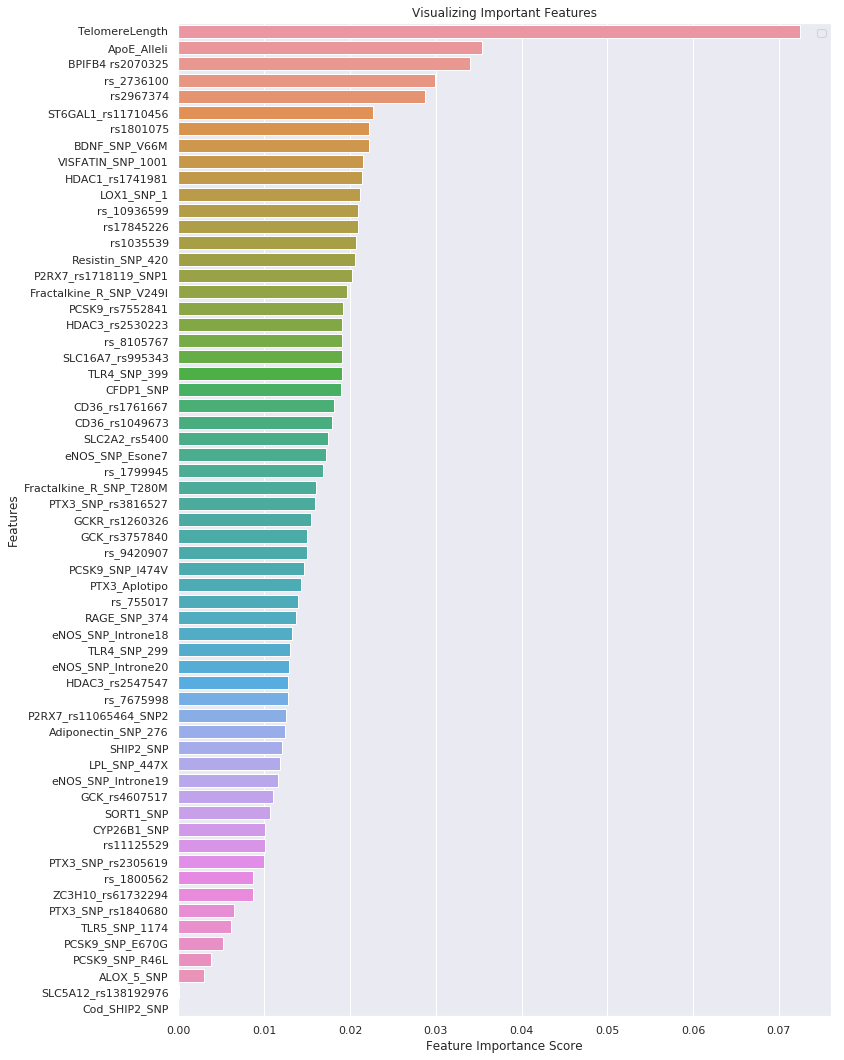

In [4]:
runRandomForestRegression(100)